<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='../../pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
</div>
</a>

# Practicum Convolution Neural Nets (CNN) Deel 1

**Doel: Toepassen Convolutional Neural Networks**

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

<h3>Globale variabelen</h3>

In [63]:
forestDirectory = '../../pics/2750/Forest'
industrialDirectory = '../../pics/2750/Industrial'

### Context

<p>
Dit practicum bestaat uit twee onderdelen
<ol>
    <li><b>Het toepassen van een convolutie en pooling filter</b></li>
    <li>Het bouwen en trainen van een eenvoudig convolutional neural net dat een industrieterrein van een bos kan onderscheiden. Voor beide oefeningen gebruiken we de EuroSAT_RGB dataset</li>
</ol>    
</p>

<img src='../../pics/eurosat_cnn.png' length=65% width=65%>

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://github.com/phelber/EuroSAT">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=40% width=40%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

## Opdrachten

### Opdracht 1: Afbeelding inladen

PyTorch module <u>read_image</u> maakt het inladen van afbeeldingen als Tensor gemakkelijk. 

<p>
Bekijk de documentatie van de <a href="https://pytorch.org/vision/stable/io.html">PyTorch io module</a> en laad de afbeelding 'Industrial_1.jpg' in variable <u>industrial</u> als een 1-dimensionale Torch Tensor met float (Scalar) waarden.
</p>

In [64]:
industrial = read_image(industrialDirectory + '/Industrial_1.jpg', mode=ImageReadMode.GRAY)
industrial = T.ConvertImageDtype(torch.float).forward(industrial)
industrial


tensor([[[0.2745, 0.2745, 0.2706,  ..., 0.8706, 0.6196, 0.4118],
         [0.2745, 0.2745, 0.2706,  ..., 0.8706, 0.6196, 0.4118],
         [0.2706, 0.2706, 0.2706,  ..., 0.8235, 0.5529, 0.4000],
         ...,
         [0.3608, 0.3608, 0.3843,  ..., 0.3765, 0.3922, 0.3843],
         [0.3020, 0.3020, 0.3098,  ..., 0.3451, 0.3765, 0.3804],
         [0.3137, 0.3137, 0.3294,  ..., 0.3569, 0.3843, 0.3843]]])

### Opdracht 2: convolutie + padding uitvoeren

<p>
De basis-ingrediënten van een CNN, convolutie en pooling, hebben we al met de hand uitgevoerd tijdens het practicum Numpy 2.
Ditmaal voeren we een convolutie filter uit met <a href="https://pytorch.org/docs/stable/nn.functional.html">PyTorch Functional</a>
</p>

<p>
Maak een <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">3 x 3 kernel</a> om een edge te detecteren en representeer de <u>square kernel met equal stride</u> als een Pytorch Tensor met naam <u>edgeFilter</u> 
</p>

In [65]:
# create kernel to detect edges
edgeFilter = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# reshape to match the expected input shape of Conv2d
edgeFilter = edgeFilter.unsqueeze(0).unsqueeze(0)

# shape should be 3
edgeFilter.shape


torch.Size([1, 1, 3, 3])

<p>
    Maak o.b.v. <u>edgeFiler</u> een Conv2d filter met als
    <ul>
        <li>naam <u>edgeConv</u></li>
        <li>kernel_size=3</li>
        <li>stride=1 (default) geeft aan hoeveel de kernel verplaatst per stap</li>
        <li>padding=0 (default) geeft aan hoe we omgaan met de randen</li>
        <li>requires_grad=True</li>
    </ul>
</p>            

In [66]:
# create conv3d filter with kernel_size = 3, stride = 1 and padding = 0
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=False)
# add edgeFilter to Conv2d as weight
conv.weight = nn.Parameter(edgeFilter)

print(conv)

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)


<p>Pas je ontworpen filter toe op 'Industrial_1.jpg'</p>

In [67]:
# apply filter with forward pass
industrialFiltered = conv.forward(industrial)
industrialFiltered

tensor([[[-1.1765e-02, -7.8431e-03, -7.8430e-03,  ..., -3.9216e-02,
          -1.5686e-01, -1.9216e-01],
         [-2.3529e-02, -2.9802e-08, -3.9215e-03,  ..., -3.5686e-01,
          -4.4706e-01, -3.7647e-01],
         [-7.4510e-02, -7.4510e-02, -8.6274e-02,  ..., -1.4863e+00,
          -1.0588e+00, -4.6275e-01],
         ...,
         [-4.7059e-02, -6.2745e-02, -1.6863e-01,  ..., -4.1569e-01,
          -4.8235e-01, -4.9020e-01],
         [-1.0588e-01, -2.2745e-01, -3.0588e-01,  ..., -2.0000e-01,
          -3.1765e-01, -2.6275e-01],
         [-1.9608e-01, -1.8824e-01, -1.9216e-01,  ...,  3.9216e-01,
           9.4118e-02, -3.5294e-02]]], grad_fn=<SqueezeBackward1>)

<p>Gebruik <u>plt.subplots</u> voor het naast elkaar weergeven van Images <u>industrial</u> en <u>industrialFiltered</u></p>
<note>HINT: kijk in notebook Numpy Opdracht 1 uit periode 1</note>

In [68]:
def plotImgs(lImg, rImg):
    plt.style.use('dark_background') 
    plt.rcParams["font.size"] = 12
    plt.rcParams["figure.figsize"] = (12, 7)

    fig, (axL, axR) = plt.subplots(ncols=2, constrained_layout=True)
    imL = axL.imshow(np.clip(lImg, 0, 1), interpolation="none")
    imR = axR.imshow(np.clip(rImg, 0, 1), interpolation="none")    

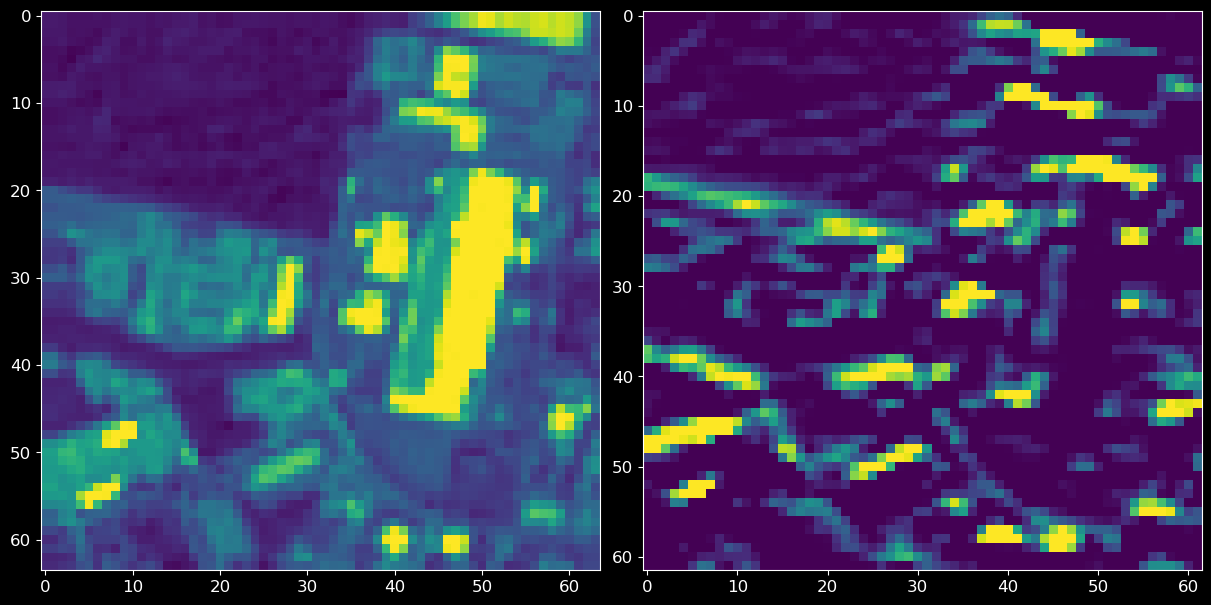

In [69]:
# squeeze tensor to correct shape and detach filtered tensor from gpu and transform to numpy to be able to show in plot
plotImgs(industrial.squeeze(), industrialFiltered.squeeze().detach().numpy())

**Herhaal bovenstaande stappen voor een Forest Image uit de EuroSAT Dataset**

In [70]:
forest = read_image(forestDirectory + '/Forest_5.jpg', mode=ImageReadMode.GRAY)
forest = T.ConvertImageDtype(torch.float).forward(forest)
forest


tensor([[[0.2353, 0.2353, 0.2431,  ..., 0.2314, 0.2431, 0.2314],
         [0.2353, 0.2353, 0.2431,  ..., 0.2314, 0.2431, 0.2314],
         [0.2392, 0.2392, 0.2588,  ..., 0.2196, 0.2235, 0.2235],
         ...,
         [0.2431, 0.2431, 0.2392,  ..., 0.2314, 0.2118, 0.2275],
         [0.2235, 0.2275, 0.2392,  ..., 0.2235, 0.2157, 0.2157],
         [0.2275, 0.2275, 0.2431,  ..., 0.2275, 0.2275, 0.2235]]])

In [71]:
# apply filter with forward pass
forestFiltered = conv.forward(forest)
forestFiltered

tensor([[[ 2.7451e-02,  6.6667e-02,  1.0980e-01,  ...,  3.9216e-03,
          -3.9216e-02, -5.8824e-02],
         [-2.7451e-02, -7.8431e-03,  2.3529e-02,  ...,  1.1765e-02,
          -3.1373e-02, -5.0980e-02],
         [-9.8039e-02, -1.8824e-01, -2.5098e-01,  ...,  3.5294e-02,
           3.9216e-02,  3.5294e-02],
         ...,
         [ 3.5294e-02,  7.8431e-03, -1.4901e-08,  ...,  1.2157e-01,
           3.9216e-02, -2.3529e-02],
         [-6.2745e-02, -3.5294e-02, -1.1765e-02,  ..., -7.0588e-02,
          -9.4118e-02, -6.6667e-02],
         [-4.3137e-02, -1.4901e-08,  3.5294e-02,  ..., -9.4118e-02,
          -1.9608e-02,  2.3529e-02]]], grad_fn=<SqueezeBackward1>)

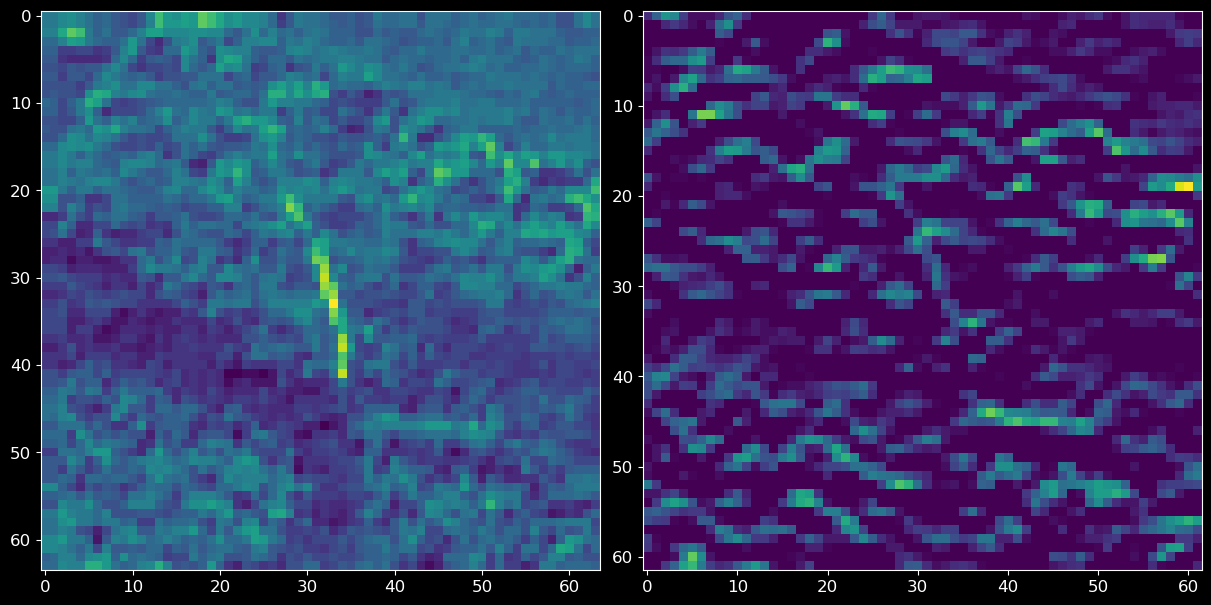

In [72]:
# squeeze tensor to correct shape and detach filtered tensor from gpu and transform to numpy to be able to show in plot
plotImgs(forest.squeeze(), forestFiltered.squeeze().detach().numpy())

### Reflectie

Zijn 'Industrial_1.jpg' en 'Forrest_1.jpg' na een convolutie beter te onderscheiden?

**Extra: varieer de stride en de padding en toon de resultaten**

### Bronnen

[EuroSAT project](https://github.com/phelber/eurosat)

[Pytorch Neural Nets](https://pytorch.org/docs/stable/nn.html)

[Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

[A simple CNN with Pytorch](https://tomroth.com.au/pytorch-cnn)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

[Using Dropout Regularization in PyTorch Models](https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models)